In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import MDS

import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
pNum = 1
nCategories = 6
print('- * - * - * - * Beginning function call * - * - * - * -')
assert isinstance(pNum, int) and pNum in range(11), 'The function requires one input (the participant number)'
assert nCategories in [6, 72], 'Number of categories must be 6 or 72.'
if pNum == 0: # If 0 was entered, update pNum to include all 10 files
    Warning('Participant number 0 entered. Running function on all 10 participants.')
    pNum = list(range(1, 11))
X, labels6, labels72, t, fs = load_data(pNum)
RSA = MatClassRSA()
Y = labels6 if nCategories == 6 else labels72
print('~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...')
Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)
print("Shape of Xr: ", Xr.shape)
print("Shape of Yr: ",Yr.shape)
print('Done.\n')
print('~ ~ Performing category-level classification on single trials ~ ~ ...')

pca = PCA(0.99)
inp = X.reshape(X.shape[2], -1)
print("Shape of inp: ",inp.shape)
X_pca = pca.fit_transform(inp)
print("Shape of X_pca: ", X_pca.shape)

- * - * - * - * Beginning function call * - * - * - * -
Participant Number:  1
Loaded input file:  S01.mat
Size of data matrix (electrodes x time x trials):  (124, 40, 5184)
Number of time samples per second (sampling rate):  62.5  Hz
Trial epoch:  -112  to  512  msec relative to stimulus onset
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Shape of Xr:  (124, 40, 5184)
Shape of Yr:  (5184, 1)
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...
Shape of inp:  (5184, 4960)
Shape of X_pca:  (5184, 3532)


In [22]:
num_folds = 10
kf = KFold(n_splits=num_folds)  # Define the number of splits (folds)
skf = StratifiedKFold(n_splits=num_folds)
model = LDA()

y_pred = cross_val_predict(model, X_pca, Y.ravel(), cv=kf, n_jobs=5, verbose=3)

# # Perform 5-fold cross-validation
# cv_results = cross_validate(model, X_pca, Y.ravel(), cv=skf, n_jobs=5,verbose=3, return_train_score=True,return_estimator=True, return_indices=True)

# # Print the results
# for key in cv_results:
#     if key != "estimator" and key != "indices":
#         print(key)
#         print(cv_results[key])
#         try:
#             print("Mean: ", np.mean(cv_results[key]))
#             print("Std: ", np.std(cv_results[key]))
#         except:
#             pass

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  5.2min finished


~ ~ Visualizing confusion matrix ~ ~ ...


Text(0.5, 1.0, '% classified CM: Single-trial 6-class accuracy 16.11%')

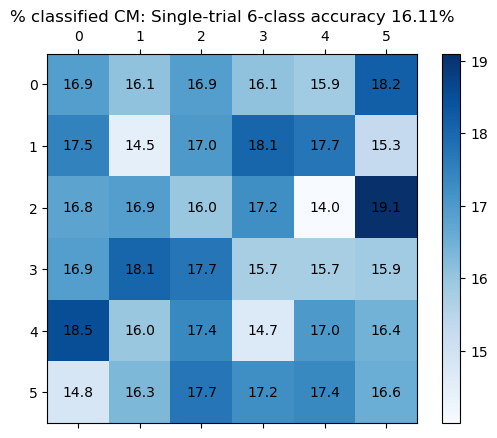

In [33]:
cm = confusion_matrix(Y.ravel(), y_pred)
accuracy = accuracy_score(Y.ravel(), y_pred)
cm_pct = 100 * cm / cm.sum(axis=1)[:, np.newaxis]
accuracy_pct = accuracy * 100
print('~ ~ Visualizing confusion matrix ~ ~ ...')
fig, ax = RSA.Visualization.plotMatrix(cm_pct, colorbar=True, matrixLabels=True)
plt.title(f'% classified CM: Single-trial 6-class accuracy {accuracy_pct:.2f}%')

In [4]:
class MatClassRSA:
    class Preprocessing:
        @staticmethod
        def shuffleData(X, Y):
            idx = np.random.permutation(len(Y))
            return X[:, :, idx], Y[idx]
    class Classification:
        @staticmethod
        def crossValidateMulti(X, Y, num_folds=10, method='PCA', variance=0.99, classifier='LDA'):
            pca = PCA(variance)
            X_pca = pca.fit_transform(X.reshape(X.shape[2], -1)) # This is the important line. Need to make sure PCA is being done
            kf = KFold(n_splits=num_folds)  # Define the number of splits (folds)
            skf = StratifiedKFold(n_splits=num_folds)
            model = LDA()

            X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.1)
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            accuracy = np.mean(Y_test == Y_pred)

            
            return cm, accuracy
    class Visualization:
        @staticmethod
        def plotMatrix(cm, colorbar=True, matrixLabels=True, axisLabels=None, axisColors=None):
            fig, ax = plt.subplots()
            cax = ax.matshow(cm, cmap=plt.cm.Blues)
            if colorbar:
                plt.colorbar(cax)
            if matrixLabels:
                for (i, j), val in np.ndenumerate(cm):
                    ax.text(j, i, f'{val:.1f}', ha='center', va='center')
            if axisLabels:
                ax.set_xticklabels([''] + axisLabels)
                ax.set_yticklabels([''] + axisLabels)
            if axisColors:
                for ticklabel, tickcolor in zip(ax.get_xticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
                for ticklabel, tickcolor in zip(ax.get_yticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
            # plt.show()
            return fig, ax
        @staticmethod
        def plotMDS(rdm, nodeLabels=None, nodeColors=None):
            mds = MDS(n_components=2, dissimilarity='precomputed')
            coords = mds.fit_transform(squareform(rdm))
            fig, ax = plt.subplots()
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')
            if nodeLabels:
                for i, label in enumerate(nodeLabels):
                    ax.text(coords[i, 0], coords[i, 1], label)
            plt.colorbar(sc)
            plt.show()
        @staticmethod
        def plotDendrogram(rdm, nodeLabels=None, nodeColors=None, yLim=None):
            linked = linkage(squareform(rdm), 'single')
            fig, ax = plt.subplots()
            dendro = dendrogram(linked, labels=nodeLabels, color_threshold=0, above_threshold_color='black', ax=ax)
            if yLim:
                plt.ylim(yLim)
            plt.show()
            
def load_data(pNum, show=True):
    X, labels6, labels72 = [], [], []
    if type(pNum) == int:
        pNum = [pNum]
    for i in pNum:
        baseFn = f'S{i:02d}.mat'
        data = sio.loadmat("./Data/"+baseFn)
        X.append(data['X'])
        labels6.append(data['labels6'])
        labels72.append(data['labels72'])
        if show == True:
            print("Participant Number: ", i)
            print("Loaded input file: ", baseFn)
            print('Size of data matrix (electrodes x time x trials): ', data['X'].shape)
            print('Number of time samples per second (sampling rate): ', data['fs'][0][0]," Hz")
            print("Trial epoch: ", data['t'][0][0], " to ", data['t'][0][-1], " msec relative to stimulus onset")   
    X = np.concatenate(X, axis=2)
    labels6 = np.concatenate(labels6)
    labels72 = np.concatenate(labels72)
    return X, labels6, labels72, data['t'], data['fs']

def main(pNum, nCategories=6):
    print('- * - * - * - * Beginning function call * - * - * - * -')
    assert isinstance(pNum, int) and pNum in range(11), 'The function requires one input (the participant number)'
    assert nCategories in [6, 72], 'Number of categories must be 6 or 72.'
    if pNum == 0: # If 0 was entered, update pNum to include all 10 files
        Warning('Participant number 0 entered. Running function on all 10 participants.')
        pNum = list(range(1, 11))
    X, labels6, labels72, t, fs = load_data(pNum)
    RSA = MatClassRSA()
    Y = labels6 if nCategories == 6 else labels72
    print('~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...')
    Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)
    print("Shape of Xr: ", Xr.shape)
    print("Shape of Yr: ",Yr.shape)
    print('Done.\n')
    print('~ ~ Performing category-level classification on single trials ~ ~ ...')
    cm, accuracy = RSA.Classification.crossValidateMulti(Xr, Yr.ravel(), 'PCA', 0.99, 'LDA')
    print('Done.\n')
    cm_pct = 100 * cm / cm.sum(axis=1)[:, np.newaxis]
    accuracy_pct = accuracy * 100
    print('~ ~ Visualizing confusion matrix ~ ~ ...')
    fig, ax = RSA.Visualization.plotMatrix(cm_pct, colorbar=True, matrixLabels=True)
    plt.title(f'% classified CM: Single-trial 6-class accuracy {accuracy_pct:.2f}%')
    plt.savefig(f'./Figures/{pNum:02d}_1a_singleTrialAllTime_CM.png')
    # print('~ ~ Visualizing MDS plot ~ ~ ...')
    # rdm = 1 - cm_pct / 100
    # RSA.Visualization.plotMDS(rdm)
    # print('~ ~ Visualizing Dendrogram ~ ~ ...')
    # RSA.Visualization.plotDendrogram(rdm)

In [ ]:
if __name__ == "__main__":
    pNum = 1
    nCategories = 6
    main(pNum, nCategories)

- * - * - * - * Beginning function call * - * - * - * -
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Done.

~ ~ Visualizing confusion matrix ~ ~ ...


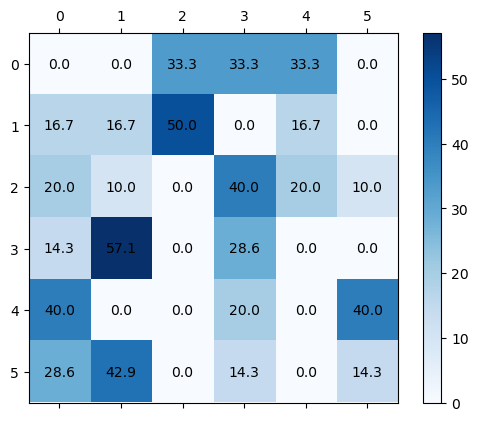

~ ~ Visualizing MDS plot ~ ~ ...


/mnt/c/Users/nonoh/AppData/Local/Temp/ipykernel_16506/4191683840.py:70: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')


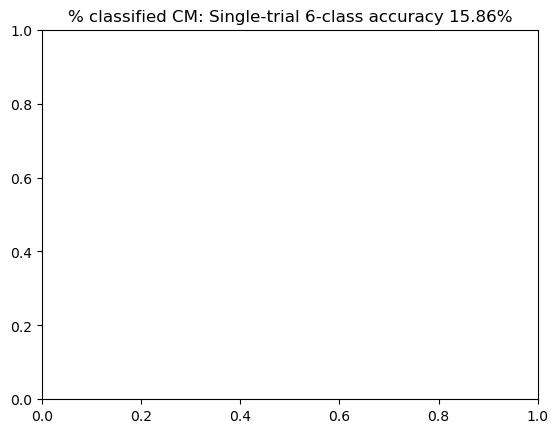

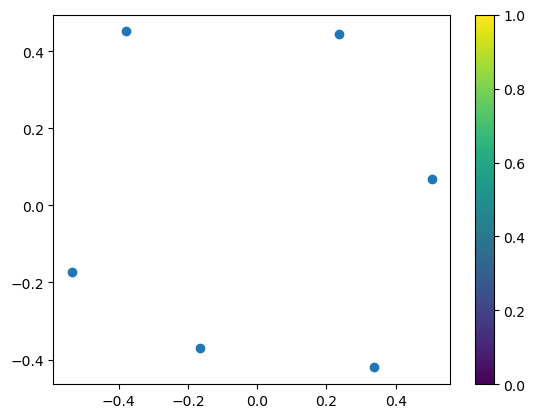

~ ~ Visualizing Dendrogram ~ ~ ...


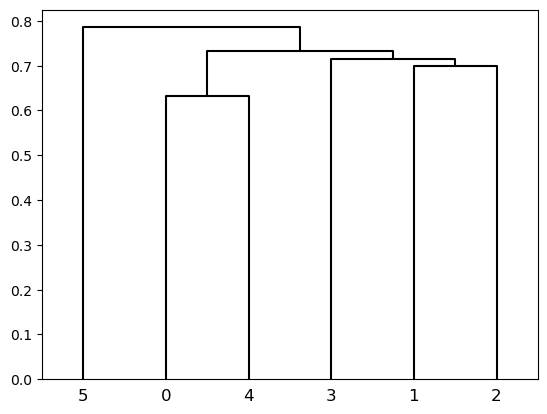

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
class MatClassRSA:
    class Preprocessing:
        @staticmethod
        def shuffleData(X, Y):
            n_samples = X.shape[0]
            idx = np.random.permutation(n_samples)
            return X[idx, :], Y[idx]  # Adjusted to index the first axis of X
    class Classification:
        @staticmethod
        def crossValidateMulti(X, Y, method='PCA', variance=0.99, classifier='LDA'):
            if method == 'PCA':
                n_samples, n_features, n_trials = X.shape
                X_reshaped = X.reshape(n_samples * n_trials, n_features)
                pca = PCA(variance)
                X_pca = pca.fit_transform(X_reshaped)
                X_pca = X_pca.reshape(n_samples, n_trials, -1)
                X_pca = X_pca.mean(axis=1)  # Averaging over trials to get (n_samples, n_components)
            lda = LDA()
            # Ensure X_pca and Y have compatible dimensions
            X_flat = X_pca.reshape(X_pca.shape[0], -1)  # Flatten for LDA
            X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)
            lda.fit(X_train, Y_train)
            Y_pred = lda.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            accuracy = np.mean(Y_test == Y_pred)
            return cm, accuracy
    class Visualization:
        @staticmethod
        def plotMatrix(cm, colorbar=True, matrixLabels=True, axisLabels=None, axisColors=None):
            fig, ax = plt.subplots()
            cax = ax.matshow(cm, cmap=plt.cm.Blues)
            if colorbar:
                plt.colorbar(cax)
            if matrixLabels:
                for (i, j), val in np.ndenumerate(cm):
                    ax.text(j, i, f'{val:.1f}', ha='center', va='center')
            if axisLabels:
                ax.set_xticklabels([''] + axisLabels)
                ax.set_yticklabels([''] + axisLabels)
            if axisColors:
                for ticklabel, tickcolor in zip(ax.get_xticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
                for ticklabel, tickcolor in zip(ax.get_yticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
            plt.show()
        @staticmethod
        def plotMDS(rdm, nodeLabels=None, nodeColors=None):
            # Make sure the distance matrix is symmetric and diagonal is zero
            rdm_symmetric = (rdm + rdm.T) / 2
            np.fill_diagonal(rdm_symmetric, 0)
            # Ensure rdm_symmetric is a square matrix
            if rdm_symmetric.shape[0] != rdm_symmetric.shape[1]:
                raise ValueError('Distance matrix must be square.')
            # Convert to condensed distance matrix format if necessary
            if rdm_symmetric.shape[0] * (rdm_symmetric.shape[0] - 1) // 2 == rdm.size:
                rdm_symmetric = squareform(rdm_symmetric)
            mds = MDS(n_components=2, dissimilarity='precomputed')
            coords = mds.fit_transform(rdm_symmetric)
            fig, ax = plt.subplots()
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')
            if nodeLabels:
                for i, label in enumerate(nodeLabels):
                    ax.text(coords[i, 0], coords[i, 1], label)
            plt.colorbar(sc)
            plt.show()
        @staticmethod
        def plotDendrogram(rdm, nodeLabels=None, nodeColors=None, yLim=None):
            # Make sure the distance matrix is symmetric
            rdm_symmetric = (rdm + rdm.T) / 2
            np.fill_diagonal(rdm_symmetric, 0)
            # Convert to condensed distance matrix format
            rdm_condensed = squareform(rdm_symmetric)
            linked = linkage(rdm_condensed, 'single')
            fig, ax = plt.subplots()
            dendro = dendrogram(linked, labels=nodeLabels, color_threshold=0, above_threshold_color='black', ax=ax)
            if yLim:
                plt.ylim(yLim)
            plt.show()
def load_data(pNum):
    X, labels6, labels72 = [], [], []
    if type(pNum) == int:
        pNum = [pNum]
    for i in pNum:
        baseFn = f'S{i:02d}.mat'
        data = sio.loadmat("./Data/"+baseFn)
        X.append(data['X'])
        labels6.append(data['labels6'])
        labels72.append(data['labels72'])
    X = np.concatenate(X, axis=2)
    labels6 = np.concatenate(labels6)
    labels72 = np.concatenate(labels72)
    return X, labels6, labels72, data['t'], data['fs']
def main(pNum, nCategories=6):
    print('- * - * - * - * Beginning function call * - * - * - * -')
    assert isinstance(pNum, int) and pNum in range(11), 'The function requires one input (the participant number)'
    assert nCategories in [6, 72], 'Number of categories must be 6 or 72.'
    if pNum == 0:
        pNum = list(range(1, 11))
    X, labels6, labels72, t, fs = load_data(pNum)
    RSA = MatClassRSA()
    Y = labels6 if nCategories == 6 else labels72
    print('~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...')
    Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)
    print('Done.\n')
    print('~ ~ Performing category-level classification on single trials ~ ~ ...')
    cm, accuracy = RSA.Classification.crossValidateMulti(Xr, Yr, 'PCA', 0.99, 'LDA')
    print('Done.\n')
    cm_pct = 100 * cm / cm.sum(axis=1)[:, np.newaxis]
    accuracy_pct = accuracy * 100
    print('~ ~ Visualizing confusion matrix ~ ~ ...')
    RSA.Visualization.plotMatrix(cm_pct, colorbar=True, matrixLabels=True)
    plt.title(f'% classified CM: Single-trial 6-class accuracy {accuracy_pct:.2f}%')
    plt.savefig(f'Figures/S{pNum:02d}_1a_singleTrialAllTime_CM.png')
    print('~ ~ Visualizing MDS plot ~ ~ ...')
    rdm = 1 - cm_pct / 100
    RSA.Visualization.plotMDS(rdm)
    print('~ ~ Visualizing Dendrogram ~ ~ ...')
    RSA.Visualization.plotDendrogram(rdm)
if __name__ == "__main__":
    pNum = 1
    nCategories = 6
    main(pNum, nCategories)